In [7]:
from spherical_analysis import *
import json
import os
import re
from scipy.optimize import minimize, brute
from scipy.fft import fft2, ifft2, fftshift, rfft2, irfft2, ifftshift
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import harmonic as tcharm
from skimage.io import imsave
import tifffile
import time
from scipy.ndimage import shift, gaussian_filter
from skimage import util, filters
from scipy import interpolate as interp
from scipy import signal
plt.set_cmap('cividis')

<Figure size 640x480 with 0 Axes>

Jupyter notebook for the development of PIV code in python.

Start with the simple question of analyzing how much an image has been translated. To quantify this, say you have two images $f_1(\vec{x})$ and $f_2(\vec{x})$. Define the *cross-correlation* of the two images as the following:
$$
(f * g)(\vec{d}) = \int f_1(\vec{x}-\vec{d})^* f_2(\vec{x})  \; d\vec{x}
$$
The rationale behind this is that you are basically computing a sliding dot product between the signals $f_1$ and $f_2$ and $\vec{d}$ controls how much you "slide" $f_1$ by. If $f_2$ is indeed a translation of $f_1$ by $\vec{d}'$, then this integral with have a maximum at $\vec{d}'$. Lets see in principle with a single image which we manually translate.

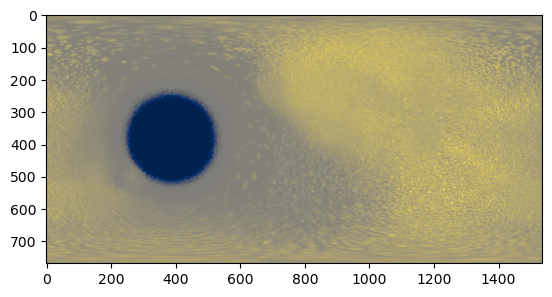

In [8]:
# read in image
im = io.imread('time45_spherical_proj.tif')
im2 = io.imread('time46_spherical_proj.tif')

# display image
plt.imshow(im)

Consider a small portion of the image. In PIV literature, this is known as the interrogation area.

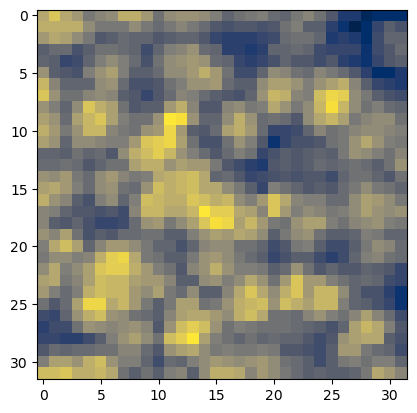

In [9]:
# set window size
win_size = 32

# set window location
win_coord_y = 300
win_coord_x = 1000

# extract and plot
im_win = im[win_coord_y:win_coord_y+win_size, win_coord_x:win_coord_x+win_size]
plt.imshow(im_win)

Consider shifting the window by some amount with periodic boundaries. (Here, we shift the image in the direction 10 pixels in the positive x and 10 pixels in the positive y direction. In image coordinate convention, the image has appeared to move 10 pixels down and 10 pixels right.)

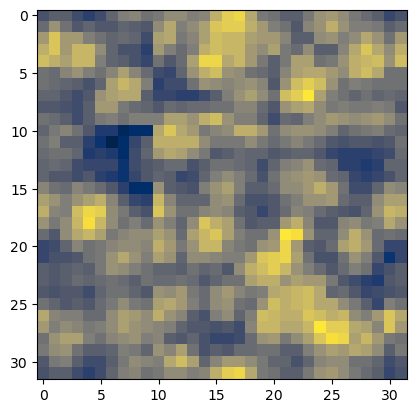

In [10]:
shift_y = 10
shift_x = 10
im_win_shifted = shift(im_win, (shift_y, shift_x), mode='wrap')
plt.imshow(im_win_shifted)

Using Fourier transforms, we can compute the cross-correlation as follows:
$$
\mathcal{F}(f_1 * f_2) = \mathcal{F}(f_1)^*\mathcal{F}(f_2) \\ 
\Rightarrow f_1 * f_2 = \mathcal{F}^{-1}\Big(\mathcal{F}(f_1)^*\mathcal{F}(f_2)  \Big)
$$
We can also plot the displacement vector on the image.

y-displacement: 10
x-displacement: 10


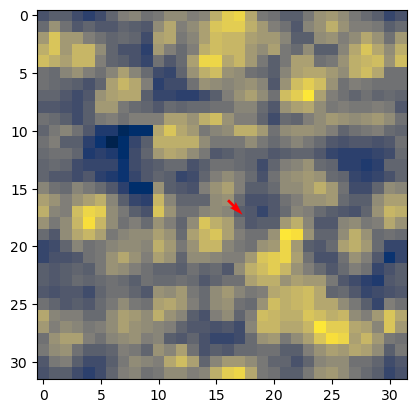

In [11]:
im_fft = np.conj(fft2(im_win))
im_shift_fft = fft2(im_win_shifted)
norm = np.abs(im_fft*im_shift_fft)
R = ifft2(im_fft*im_shift_fft)
R = np.abs(R)
displacement = np.unravel_index(np.argmax(R), R.shape)

print(f"y-displacement: {displacement[0]}\nx-displacement: {displacement[1]}")
plt.imshow(im_win_shifted)
plt.quiver(16, 16, 10, 10, color='red', angles='xy') 
# angles='xy' makes sure the vector points in a direction that is set by the axes.
# in this case, the image axis means that 10,10 will be 10 down and 10 to the right.

We can also try different shifts to further test this out. I am anticipating a problem here, since I have played with this on my own before.  
So let's write a function that allows use to test this function efficiently.

In [12]:
def create_shifter(image, win_size, win_y, win_x):
    """Instantiates the following function:"""
    def check_shift(shift_y, shift_x):
        """Compares the shift detected by manually shifting the interrogation window
        by variables shift_y and shift_x versus the shift detected by cross correlation."""
        im_win = image[win_y:win_y + win_size, win_x:win_x + win_size]
        # the negative sign is here since by image convension, y starts from the top of the image.
        im_win_shifted = shift(im_win, (shift_y, shift_x), mode='wrap')
        im_fft = np.conj(fft2(im_win))
        im_shift_fft = fft2(im_win_shifted)
        R = ifft2(im_fft*im_shift_fft)
        displacement = np.unravel_index(np.argmax(R), R.shape)
        print(f"Window displacement: (y: {shift_y}, x: {shift_x})\nDetected displacement: (y: {displacement[0]}, x: {displacement[1]})\n")
    
    return check_shift

# test the to see if displacement makes sense
shift_check = create_shifter(im, 32, 300, 1000)
shift_check(10, 10)
shift_check(2,15)
shift_check(-2,-3)
shift_check(-5,10)
shift_check(-15, 10)
shift_check(-30, -31)
shift_check(-15, 20)
shift_check(16, 20)

Window displacement: (y: 10, x: 10)
Detected displacement: (y: 10, x: 10)

Window displacement: (y: 2, x: 15)
Detected displacement: (y: 2, x: 15)

Window displacement: (y: -2, x: -3)
Detected displacement: (y: 30, x: 29)

Window displacement: (y: -5, x: 10)
Detected displacement: (y: 27, x: 10)

Window displacement: (y: -15, x: 10)
Detected displacement: (y: 17, x: 10)

Window displacement: (y: -30, x: -31)
Detected displacement: (y: 1, x: 0)

Window displacement: (y: -15, x: 20)
Detected displacement: (y: 17, x: 20)

Window displacement: (y: 16, x: 20)
Detected displacement: (y: 16, x: 20)



We notice that at most, the detected displacement can only take positive values, and that makes sense since the inverse fft is only defined for values on $[0, 31] \times [0,31]$. Or more generally, $[0, \mathrm{window\_size} -1] \times [0, \mathrm{window\_size}-1]$. This is also due to the fact that the fft computation inherently assumes circular boundaries. Which means that there is an ambiguity for moderate shifts about half the window size (e.g. a detected shift of $16\hat{x}$ can just as  easily be detected as a shift of $-16\hat{x}$.) Therefore, this method is only valid for shifts that are within $|\mathrm{window\_size}-1|/2$. (In reality the reliable shifts are less than this, since the sub images you compare are not circularly shifted. In addition, due to local non-linearities in the flow, the reliable window shrinks even further. *In PIV literature, it is generally recognized to pick an interrogation window such that the expected displacement of particles between two frames is roughly one-quarter of the size of the interrogation window.* ) The correction formula are included in the code below.
We will have to pay special attention to the size of the interrogation window we select. 

In [13]:
def create_shifter(image, win_size, win_y, win_x):
    """Instantiates the following function:"""
    def check_shift(shift_y, shift_x):
        """Compares the shift detected by manually shifting the interrogation window
        by variables shift_y and shift_x versus the shift detected by cross correlation."""
        im_win = image[win_y:win_y + win_size, win_x:win_x + win_size]
        # the negative sign is here since by image convension, y starts from the top of the image.
        im_win_shifted = shift(im_win, (shift_y, shift_x), mode='wrap')
        im_fft = np.conj(fft2(im_win))
        im_shift_fft = fft2(im_win_shifted)
        R = ifft2(im_fft*im_shift_fft)
        displacement = np.array(np.unravel_index(np.argmax(R), R.shape))
        if displacement[0] > (win_size-1)/2:
            displacement[0] = displacement[0] - win_size
        if displacement[1] > (win_size-1)/2:
            displacement[1] = displacement[1] - win_size
        print(f"Window displacement: (y: {shift_y}, x: {shift_x})\nDetected displacement: (y: {displacement[0]}, x: {displacement[1]})\n")
    
    return check_shift

# test the to see if displacement makes sense
shift_check = create_shifter(im, 32, 300, 1000)
shift_check(10, 10)
shift_check(16, 12)
shift_check(2,15)
shift_check(-2,-3)
shift_check(-5,10)
shift_check(-15, 10)
shift_check(-16, 10)
shift_check(-15, 10)
shift_check(18,16) # this one isn't accurate since the one of the shifts is greater than the window size divided by 2

Window displacement: (y: 10, x: 10)
Detected displacement: (y: 10, x: 10)

Window displacement: (y: 16, x: 12)
Detected displacement: (y: -15, x: 12)

Window displacement: (y: 2, x: 15)
Detected displacement: (y: 2, x: 15)

Window displacement: (y: -2, x: -3)
Detected displacement: (y: -2, x: -3)

Window displacement: (y: -5, x: 10)
Detected displacement: (y: -5, x: 10)

Window displacement: (y: -15, x: 10)
Detected displacement: (y: -15, x: 10)

Window displacement: (y: -16, x: 10)
Detected displacement: (y: -16, x: 10)

Window displacement: (y: -15, x: 10)
Detected displacement: (y: -15, x: 10)

Window displacement: (y: 18, x: 16)
Detected displacement: (y: -13, x: -16)



Now that we are able to calculate the displacement for a single interrogation window, we can try to calculate the displacement field over the entire image. For now, we shall require 4 inputs: image at $t_n$, image at $t_{n+1}$, field points where the flow is evaluated, and the size of the interrogation window.   
The next two code blocks contain code which can calculate the flow field at field points.

In [14]:
def get_shift(sub_im1, sub_im2, win_size):
    """Computes the shift between two images using cross correlation.
    
    Returns
    -------
    displacement: 2 valued array with the first being displacement in y and the second being displacement in x.
    """
    sub_im1_fft = np.conj(fft2(sub_im1))
    sub_im2_fft = fft2(sub_im2)
    R = ifft2((sub_im1_fft * sub_im2_fft))
    displacement = np.array(np.unravel_index(np.argmax(R), R.shape))
    if displacement[0] > (win_size-1)/2:
            displacement[0] = displacement[0] - win_size
    if displacement[1] > (win_size-1)/2:
            displacement[1] = displacement[1] - win_size
    # R = signal.correlate(sub_im1, sub_im2)
    # displacement = np.array(np.unravel_index(np.argmax(R), R.shape)) - np.array([win_size, win_size]) + 1 # from open PIV
    return displacement

def interpolate_image(im):
       """Returns a RegularGridInterpolator object made with points in an image."""
       x_max, y_max = np.shape(im)
       x_pts = np.arange(0, x_max)
       y_pts = np.arange(0, y_max)
       return interp.RegularGridInterpolator((x_pts, y_pts), im, method='nearest', bounds_error=False, fill_value=0)

def create_window(win_size, field_point):
       """Generates a 2D meshgrid of integer coordinates the size of win_size centered about a field point."""
       x_win = np.arange(0, win_size) + field_point[0] - win_size/2
       y_win = np.arange(0, win_size) + field_point[1] - win_size/2
       return np.meshgrid(x_win, y_win, indexing='ij')

In [15]:
def get_dfield(im1, im2, field_points, win_size):
    """Gets the displacement field from im1 to im2 using PIV method.

    Parameters
    ----------
    im1: A 2D array representing image 1\n
    im2: A 2D array representing image 2\n
    field_points: (Y, X) A tuple containing corresponding y and x points where displacement field is to be calculated
    win_size: (int) Size of interrogation window for calculating field points.

    Returns
    -------
    field_values: (U, V) A tuple containing corresponding u and v components of displacement vectors calculated at field_points.
    """
    # unpack field_points
    field_points = np.array(field_points)

    # this form is a n by 2 array of (x, y) points
    field_point_list = np.flip(field_points.T, axis=1)

    # TODO: Use map_coordinates as it is better defined for image data and faster
    U = np.zeros_like(field_points[0])
    V = np.zeros_like(field_points[1])
    for i, field_point in enumerate(field_point_list):
        xg, yg = create_window(win_size, field_point)
        sub_im1 = ndimage.map_coordinates(im1, (xg, yg), order=1, prefilter=False) # recommend prefilter=True if order > 1
        sub_im2 = ndimage.map_coordinates(im2, (xg, yg), order=1, prefilter=False)
        u, v = get_shift(sub_im1, sub_im2, win_size)
        U[i] = u
        V[i] = v
    return (U, V)

Let's test this out! first, generate a field of points where we want to evaluate the displacements at.

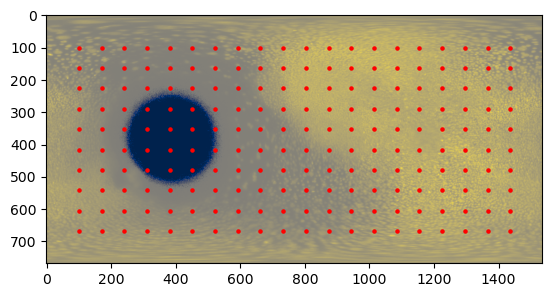

In [16]:
pad = 100
x_max, y_max = np.shape(im)
x_pts = np.linspace(pad, x_max-pad, 10) 
y_pts = np.linspace(pad, y_max-pad, 20)
xg, yg = np.meshgrid(x_pts, y_pts, indexing='ij')
field_points = (np.ravel(yg), np.ravel(xg))
plt.imshow(im)
plt.scatter(field_points[0], field_points[1], c='r', s=5)

We compare image 1 and image 2.

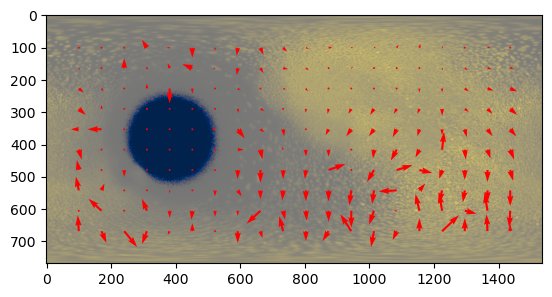

In [17]:
dfield = get_dfield(im, im2, field_points, 36)
plt.imshow(im2)
plt.quiver(field_points[0], field_points[1], dfield[0], dfield[1], scale=500, color='red', angles='xy') 

Now we compare image 1 with a shifted version of itself.

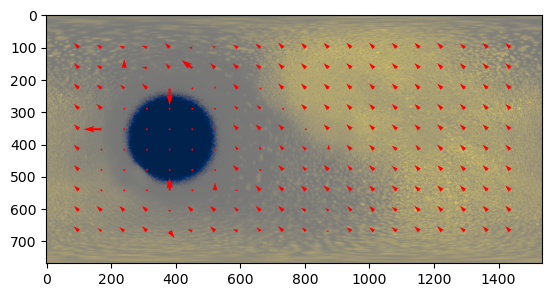

In [18]:
dfield = get_dfield(im, shift(im, (-5, -5), mode='wrap'), field_points, 36)
plt.imshow(im2)
plt.quiver(field_points[0], field_points[1], dfield[0], dfield[1], scale=500, color='red', angles='xy') 

We see that there's noise that are present in these vector fields. (How do we deal with that?)

- Multipass interrogation: Start with larger windows and refine with smaller ones to increase accuracy.
- Preprocess: Can increase contrast of the image, or ensure uniform illumination and contrast across the image.
- Window the sub-images. (I have read it as a suggestion but forgot why it helps.)

One way to ensure uniform illumination is to subtract the image with an gaussian blurred (use large kernel size) version of itself. The rationale is that applying a gaussian kernel extracts the local background intensity, thus subtracting this from the original image accounts for flucuations in the background intensity. Let's try this!

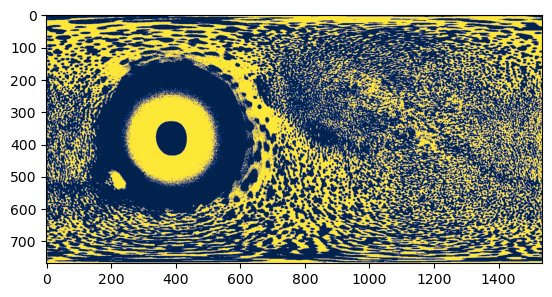

In [21]:
sigma_x = im.shape[0]/100
sigma_y = im.shape[1]/100
im_blur = gaussian_filter(im, (36, 36))
plt.imshow(im - im_blur)

I don't think it worked that well. Going to try enhancing contrast, then noramalizing all images to have intensity 0 and mean 1.

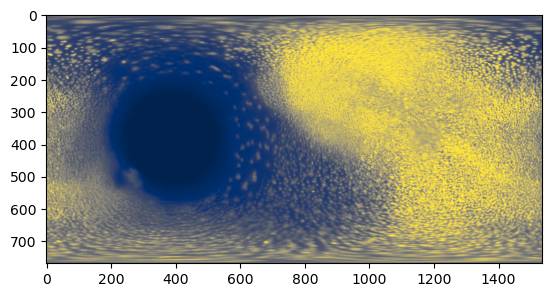

In [22]:
from skimage import exposure
im_p = exposure.equalize_hist(im)
im_p = (im_p - np.mean(im_p))/np.std(im_p)
plt.imshow(im_p)

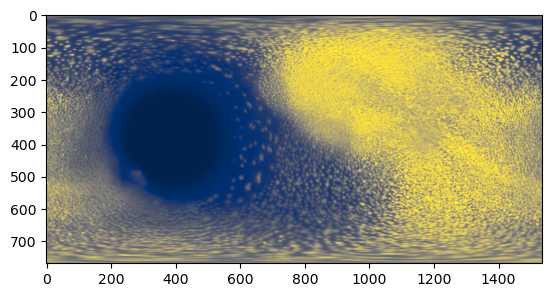

In [23]:
im2_p = exposure.equalize_hist(im2)
im2_p = (im2_p - np.mean(im2_p))/np.std(im2_p)
plt.imshow(im2_p)

Calculating displacement field now:

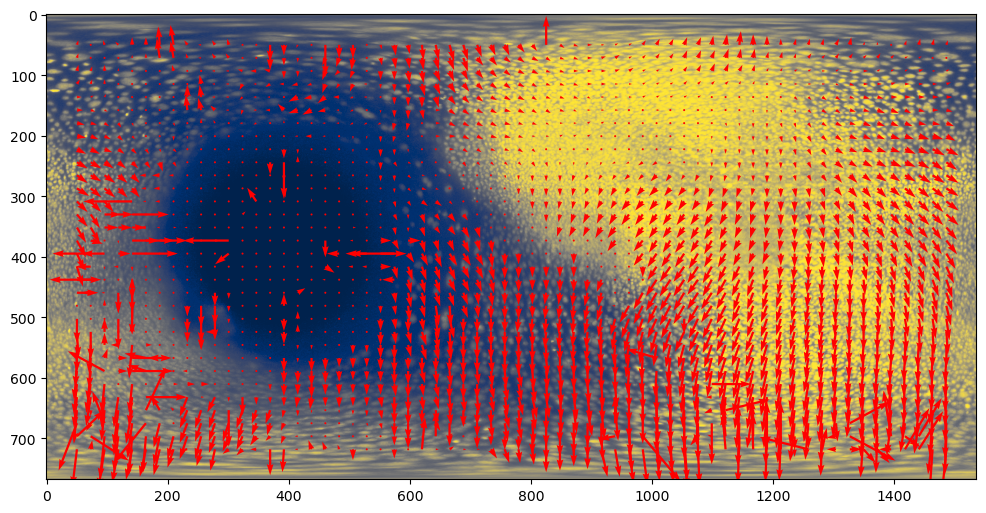

In [24]:
pad_y = 50
pad_x = 50
x_max, y_max = np.shape(im)
x_pts = np.linspace(pad_x, x_max-pad_x, 32) 
y_pts = np.linspace(pad_y, y_max-pad_y, 64)
xg, yg = np.meshgrid(x_pts, y_pts, indexing='ij')
field_points = (np.ravel(yg), np.ravel(xg))
dfield = get_dfield(im_p, im2_p, field_points, 64)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(im2_p)
ax.quiver(field_points[0], field_points[1], dfield[0], dfield[1], color='red', angles='xy', )

We can also try a local normalization method suggested by Raffel et. al. (pg 159) [original citation](https://bigwww.epfl.ch/sage/soft/localnormalization/) Which claims that image contrast enhancement is to subtract a gaussian filtered version of the image like we did before and then divide by its local variance:
$$
I_\mathrm{out} = \frac{I - M_I}{\sigma_I}
$$
Where $M_I$ is the gaussian filtered version with size $\sigma_1$ and $\sigma_I$ is the local variance image with size $\sigma_2$. Usually, $\sigma_1 < \sigma_2$.  
The local variance is defined as:
$$
V(x, y) = \int dx' dy' \, (I(x', y') - \mu(x', y'))^2\, K(x-x', y-y') = \int_{\mathcal{D}(x,y)} dx' dy' \, (I(x', y') - \mu(x', y'))^2
$$
Where $K(x, y)$ is a uniform kernel (or mean kernel) which is $1/A(\mathcal{D})$ for $(x, y) \in \mathcal{D}$ and 0 otherwise, and $\mu(x, y)$ is the mean filtered image, defined by:
$$
\mu(x, y) = \int dx' dy' \, I(x',y')K(x-x', y-y') = \frac{1}{A} \int_{\mathcal{D}(x, y)} dx' dy' \, I(x', y')
$$
This is just another way of writing moving average. **FIX THE ABOVE: $\sigma_I$ and the mean image is also calculated with a gaussian kernel** **Also I have tried tinkering with their implementtaion for hours and it doesn't work**

In [31]:
plt.set_cmap('cividis')

<Figure size 640x480 with 0 Axes>

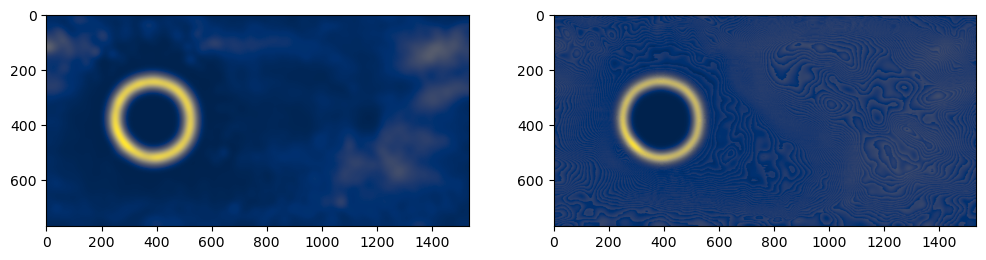

In [19]:
# define three different local averaging functinos.
def local_avg2(im, kernel_size=1):
    return ndimage.uniform_filter(im, kernel_size)
def local_avg3(im, kernel_size=1):
    return ndimage.gaussian_filter(im, sigma=kernel_size)
def local_avg(im, kernel_size=1):
    kernel = np.ones((kernel_size, kernel_size))/kernel_size**2
    return ndimage.convolve(im, kernel )

def local_var3(im, kernel_size=1):
    mu = local_avg3(im, kernel_size=kernel_size)
    return local_avg3((im-mu)**2, kernel_size=kernel_size)

def local_var2(im, kernel_size=1):
    mu = local_avg2(im, kernel_size=kernel_size)
    return local_avg2((im-mu)**2, kernel_size=kernel_size)


mu = local_avg3(im, kernel_size=16)
I_sq = local_avg3(im**2, kernel_size=16)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))
ax1.imshow(local_var3(im, kernel_size=16))
ax2.imshow(I_sq-mu**2)

Lets subtract the mean image and divide out by the variance.

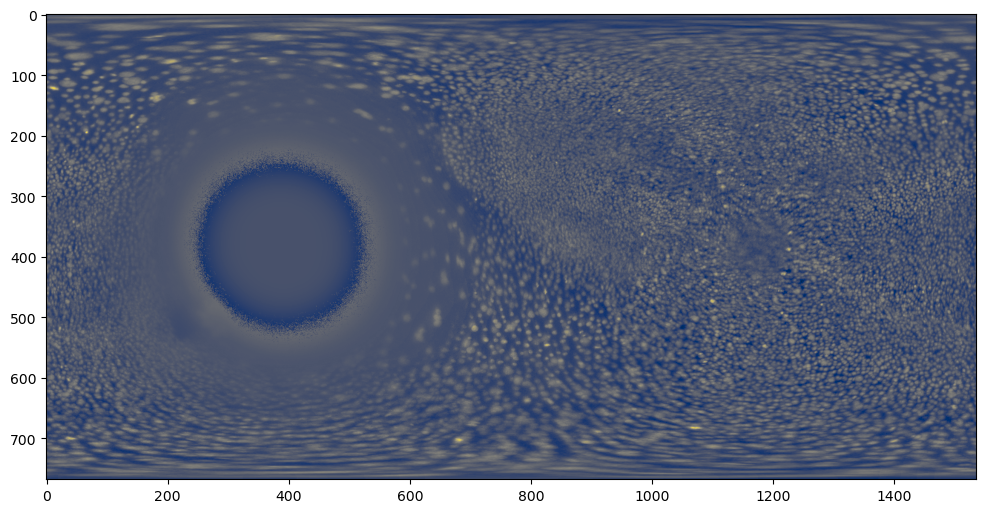

In [20]:
# use local_avg3 since it is recommended to use gaussian filters
mu =  local_avg3(im, kernel_size=32).astype(np.float64)
var = local_var3(im, kernel_size=64).astype(np.float64)
fig, ax = plt.subplots(figsize=(12,8))
plt.imshow((im-mu)/np.sqrt(var)) 

After tinkering around I found that the above works with `im/np.sqrt(var)` looking the best. Trying `(im-mu)/np.sqrt(var)` and following their suggestion just looks terrible. Okay nevermind, `im/np.sqrt(var) - mu/np.sqrt(var)` yields a reasonable result for some reason.

After some more tinkering, I figured out the reason. We need to use floats for this operation to avoid overflows! Since for integers, going negative means you wrap around and that is bad news that usually goes unnoticed if you are subtracting by a constant.

Now, lets package this into a function. There are two different implementations. The second one saves you from calculating another mean image and is slightly faster. Overall there doesn't seem to be that big of a difference between the two methods. To summarize, we have that the local noramlized image is:
$$
I_\mathrm{out}(\vec{r}) = \displaystyle\frac{I(\vec{r}) - \mu({\vec{r}|\sigma_1})}{\displaystyle\sqrt{\int d\vec{r}'\,(I(\vec{r'}) - \mu(\vec{r'}|\sigma_2))^2 \, K(\vec{r}-\vec{r'} | \sigma_2)}}
$$
Or:
$$
I_\mathrm{out}(\vec{r}) = \displaystyle\frac{I(\vec{r}) - \mu({\vec{r}|\sigma_1})}{\displaystyle\sqrt{\int d\vec{r}'\,(I(\vec{r'}) - \mu(\vec{r'}|\sigma_1))^2 \, K(\vec{r}-\vec{r'} | \sigma_2)}}
$$
Where:
$$
\mu(\vec{r}|\sigma) = \int d\vec{r}'\, I(\vec{r'})\,K(\vec{r}-\vec{r'}|\sigma)
$$

NameError: name 'local_normalization' is not defined

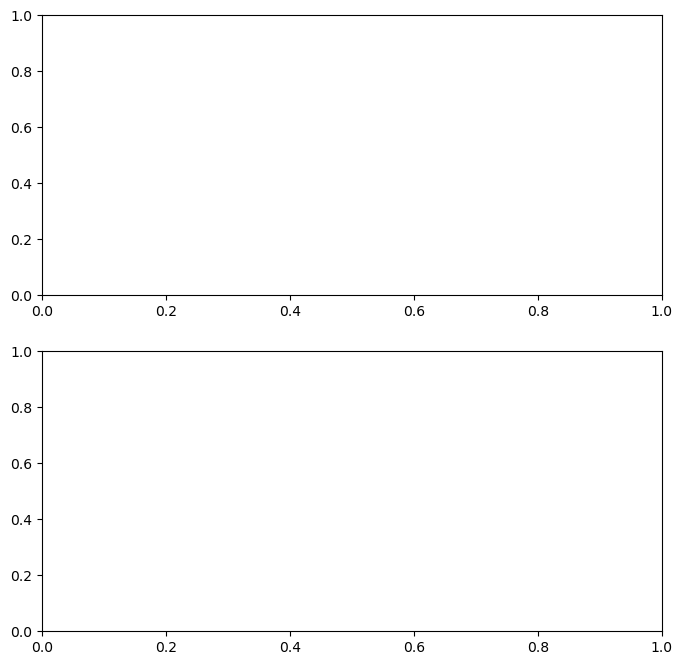

In [21]:
# def local_normalization(im, sigma_1, sigma_2):
#     def local_avg3(im, kernel_size=1):
#         return ndimage.gaussian_filter(im, sigma=kernel_size)

#     def local_var3(im, kernel_size=2):
#         mu = local_avg3(im, kernel_size=kernel_size)
#         return local_avg3((im-mu)**2, kernel_size=kernel_size)
    
#     mu = local_avg3(im, kernel_size=sigma_1).astype(np.float64)
#     var = local_var3(im, kernel_size=sigma_2).astype(np.float64)

#     return (im - mu)/np.sqrt(var)

def local_normalization2(im, sigma_1, sigma_2):
    def local_avg3(im, kernel_size=1):
        return ndimage.gaussian_filter(im, sigma=kernel_size)
    
    mu = local_avg3(im, kernel_size=sigma_1).astype(np.float64)
    var = local_avg3((im-mu)**2, kernel_size=sigma_2).astype(np.float64)

    return (im - mu)/np.sqrt(var)

def local_std(im, kernel_size=2):
    def local_avg3(im, kernel_size=1):
        return ndimage.gaussian_filter(im, sigma=kernel_size)
    mu = local_avg3(im, kernel_size=kernel_size)
    return np.sqrt(local_avg3((im-mu)**2, kernel_size=kernel_size))

def local_avg(im, kernel_size=2):
    return ndimage.gaussian_filter(im, sigma=kernel_size)


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.imshow(local_normalization(im, 32, 128))
ax2.imshow(local_normalization2(im, 32, 128))

In [22]:
im_norm = local_normalization2(im, 32, 128)
im2_norm = local_normalization2(im2, 32, 128)

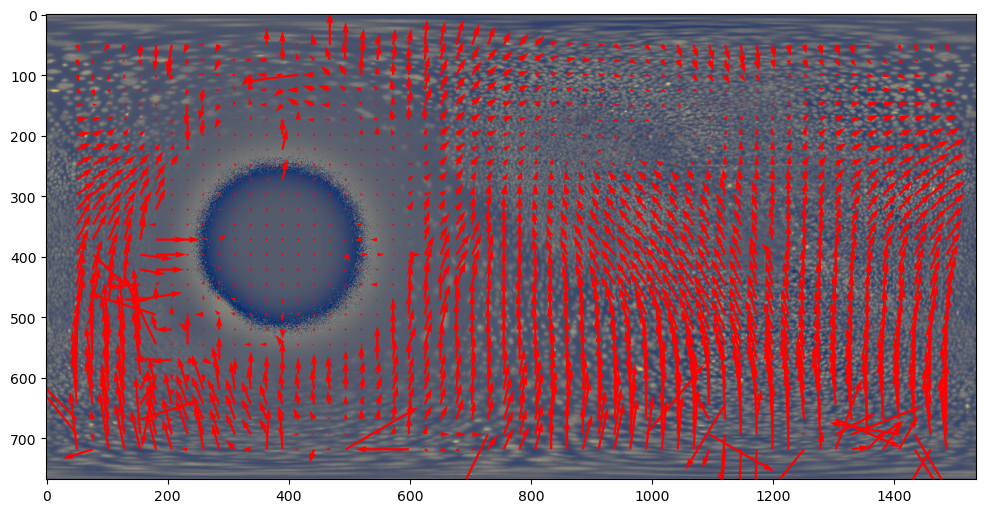

In [23]:
pad_y = 50
pad_x = 50
x_max, y_max = np.shape(im_norm)
x_pts = np.linspace(pad_x, x_max-pad_x, 28) 
y_pts = np.linspace(pad_y, y_max-pad_y, 56)
xg, yg = np.meshgrid(x_pts, y_pts, indexing='ij')
field_points = (np.ravel(yg), np.ravel(xg))
dfield = get_dfield(im_norm, im2_norm, field_points, 64)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(im2_norm)
ax.quiver(field_points[0], field_points[1], dfield[0], -dfield[1], color='red', angles='xy', scale=400) # not sure but maybe there should be a sign on dfield[1]

Okay, this doesn't seem to do much, but local noramlization will certainly have its applications. Let's try to implement multi-pass interrogation now. Here are some useful links to read up: [link1](https://faculty.hitsz.edu.cn/ueditor/jsp/upload/file/20241205/1733373906695030475.pdf), [link2](https://link.springer.com/book/10.1007/978-3-319-68852-7)

Before I implement multipass interrogation I need to make to define my interrogation grid better. They way I have it now, the spacing of the grid is not at all related to the size of the interrogation window. 
- the function will have an overlap parameter which we can manually tune. Having windows overlap means you are essentially taking into accound some of the same spatial regions twice, which can serve as a good interpolator of your velocity field [src](https://link.springer.com/article/10.1007/s003480100281)

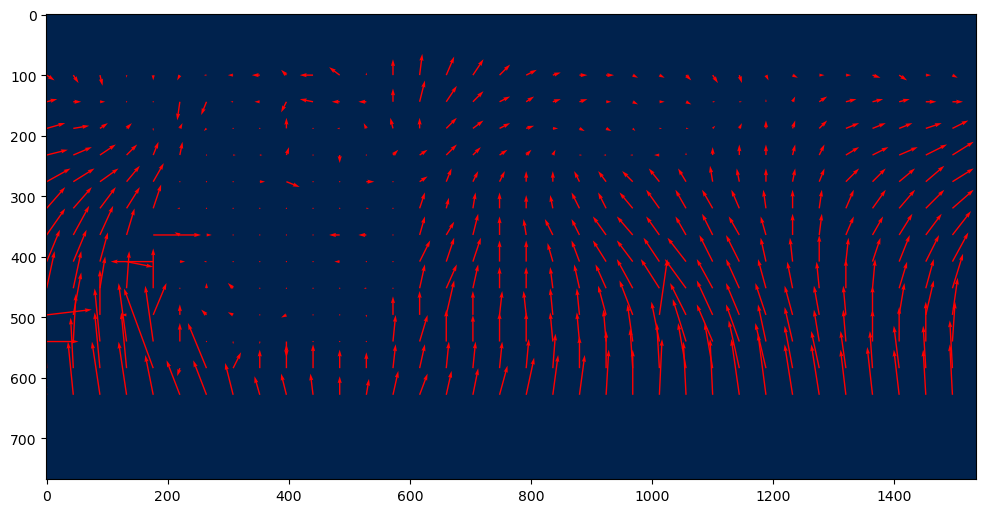

In [174]:
# outline

def make_grid(arr, win_size, overlap=0, top_pad=0, bottom_pad=0, left_pad=0, right_pad=0):
    x_max, y_max = np.shape(arr)
    spacing = win_size - overlap
    x_pts = np.arange(left_pad, x_max-right_pad, spacing) 
    y_pts = np.arange(top_pad, y_max - bottom_pad, spacing)
    xg, yg = np.meshgrid(x_pts, y_pts, indexing='ij')
    field_points = (np.ravel(yg), np.ravel(xg))
    return field_points, (xg, yg) 

win_size= 80
overlap = 36
field_points, field_grid = make_grid(im2_norm, win_size, overlap=overlap, left_pad=100, right_pad=100)
dfield = get_dfield(im_norm, im2_norm, field_points, 64)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(im2_norm, vmin=np.max(im2_norm))
ax.quiver(field_points[0], field_points[1], dfield[0], -dfield[1], color='red', angles='xy', width=0.0015, scale=350)

The field is extremely noisy, the first line of attack is to do median filtering. We first turn the displacement field into the shape of our coordinate grids and filter

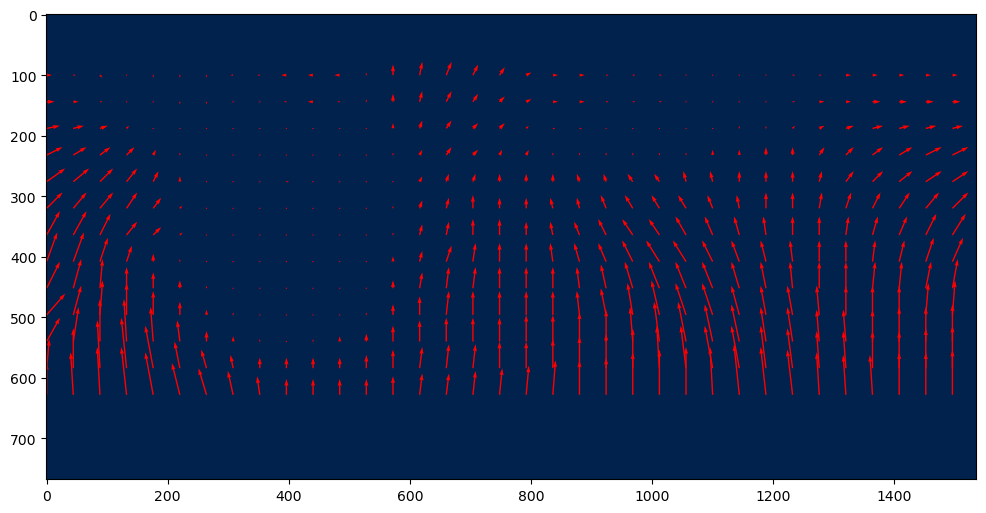

In [200]:
# turn the fields into grids
grid_shape = field_grid[0].shape
dfield_x_grid = dfield[0].reshape(grid_shape)
dfield_y_grid = dfield[1].reshape(grid_shape)

# median filter
s = 1
# dfield_x_filtered = np.ravel(ndimage.median_filter(dfield_x_grid, size=s))
# dfield_y_filtered = np.ravel(ndimage.median_filter(dfield_y_grid, size=s))
dfield_x_filtered = np.ravel(local_avg(dfield_x_grid, s))
dfield_y_filtered = np.ravel(local_avg(dfield_y_grid, s))

# plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(im2_norm, vmin=np.max(im2_norm))
ax.quiver(field_points[0], field_points[1], dfield_x_filtered, -dfield_y_filtered, color='red', angles='xy', width=0.0015, scale=350)

Indeed, it does in fact look smoother. Another way we can do this is to have a veto'ing system. Compute the local mean and standard deviation of the vector field components. Any vector component that is outside a set threshold like greater than some $n\sigma$ away from the mean is flagged. We can then use GPR (I'll implement myself) to interpolate a smooth vector field over the region. 
Locally, we will have a mean vector component $\mu_i$ and some standard deviation $\sigma_i$. The deviation is then $\delta v_i = |v_i - \mu_i|$. If $\delta v_i > n\sigma$ where $n$ is arbitrarily set by the user, that vector component is flagged.

In [176]:
local_std_dx = local_std(dfield_x_grid, kernel_size=3)
local_mean_dx = local_avg(dfield_x_grid, kernel_size=3)
local_std_dy = local_std(dfield_y_grid, kernel_size=3)
local_mean_dy = local_avg(dfield_y_grid, kernel_size=3)

In [177]:
np.std(dfield_x_grid)

3.4441881588294625

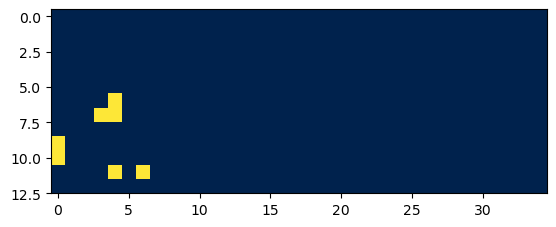

In [179]:
delta_x_field = np.abs(dfield_x_grid-local_mean_dx)
plt.imshow(delta_x_field > 6)
# get indices
to_interp_indices_x = np.where(delta_x_field > 6)
observed_indices_x = np.where(delta_x_field <= 6)

In [180]:
np.std(dfield_y_grid)

6.183389054983458

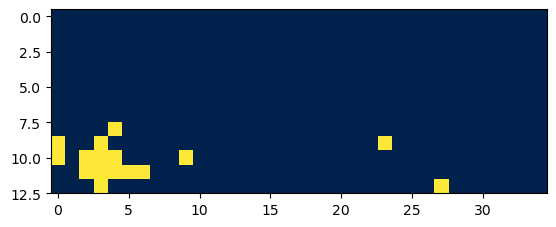

In [182]:
delta_y_field = np.abs(dfield_y_grid-local_mean_dy)
plt.imshow(delta_y_field > 8)
to_interp_indices_y = np.where(delta_y_field > 8)
observed_indices_y = np.where(delta_y_field <= 8)

Gaussian Processes Interpolation 

In [164]:
np.asarray(observed_indices_x).shape

(2, 6053)

In [183]:
observed_data_u

array([ 3,  3,  2, ..., -2, -2, -2])

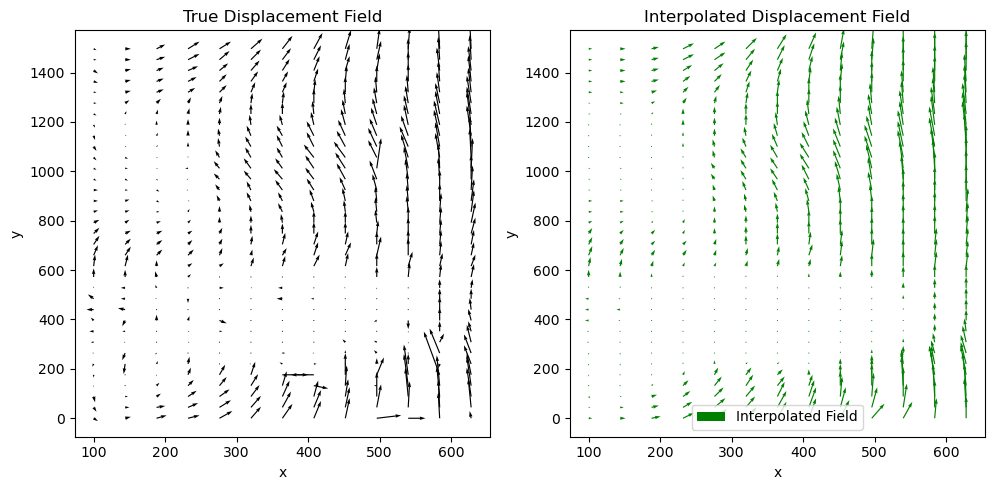

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


X, Y = field_grid
coordinates = np.vstack([X.ravel(), Y.ravel()]).T  # Shape: (N, 2)

# Add noise to simulate real-world observations
noise_std = 0.1

# get observed data
observed_data_u = dfield_x_grid[observed_indices_x]
observed_data_v = dfield_y_grid[observed_indices_y]

# Define the Gaussian Process kernel
kernel = C(1e-2, (1e-3, 1e3)) * RBF(length_scale=50.0, length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process models for u and v components separately
gp_u = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_v = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the models
gp_u.fit(np.asarray(observed_indices_x).T, observed_data_u)  # u-component
gp_v.fit(np.asarray(observed_indices_y).T, observed_data_v)  # v-component

# Predict the displacement field at all coordinates
predicted_u, std_u = gp_u.predict(coordinates, return_std=True)
predicted_v, std_v = gp_v.predict(coordinates, return_std=True)

# Reshape predictions for visualization
predicted_u = predicted_u.reshape(X.shape)
predicted_v = predicted_v.reshape(X.shape)
std_u = std_u.reshape(X.shape)
std_v = std_v.reshape(X.shape)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot true original field
plt.subplot(1, 3, 1)
plt.quiver(X, Y, dfield_x_grid, dfield_y_grid)
plt.title("True Displacement Field")
plt.xlabel("x")
plt.ylabel("y")

# # Plot observed displacements
# plt.subplot(1, 3, 2)
# #plt.scatter(observed_coords[:, 0], observed_coords[:, 1], c='r', label="Observed Points")
# plt.quiver(X, Y, observed_displacements[:, 0].reshape(X.shape), observed_displacements[:, 1].reshape(X.shape))
# plt.title("Observed Displacements")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()

# Plot interpolated displacement field
plt.subplot(1, 3, 2)
plt.quiver(X, Y, dfield_x_filtered, dfield_y_filtered, color='g', label="Interpolated Field") # Note working
plt.title("Interpolated Displacement Field")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()